In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


Holidays Events:
         date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  

Oil:
         date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20

Sample Submission:
        id  sales
0  3000888    0.0
1  3000889    0.0
2  3000890    0.0
3  3000891    0.0
4  3000892    0.0

Stores:
   store_nbr           city                           state type  cluster
0          1          Quito      

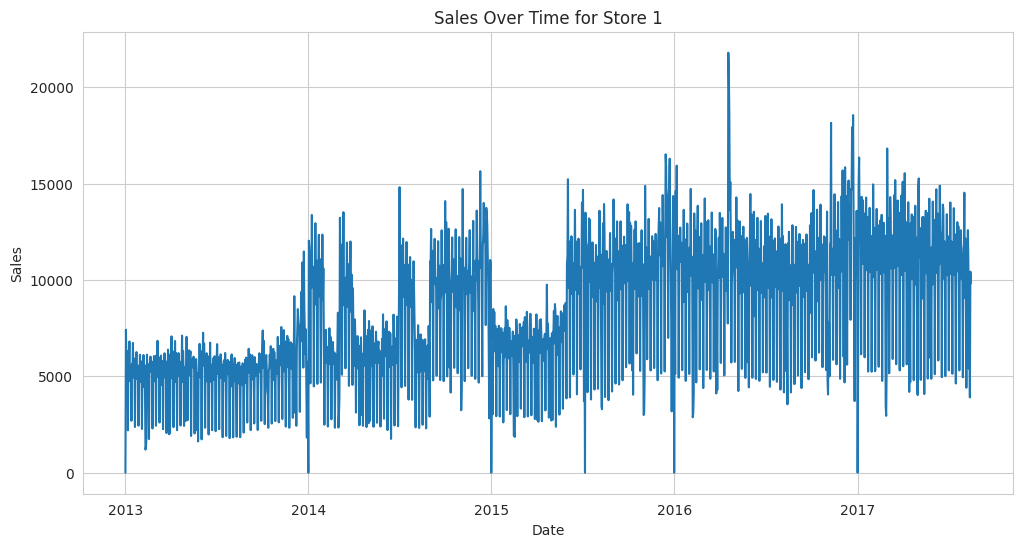

/tmp/ipykernel_19/1618739800.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays['ds'] = pd.to_datetime(holidays['ds'])
/opt/conda/lib/python3.10/site-packages/prophet/forecaster.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:08:34 - cmdstanpy - INFO - Chain [1] start processing
21:08:49 - cmdstanpy - INFO - Chain [1] done processing
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of Datetim

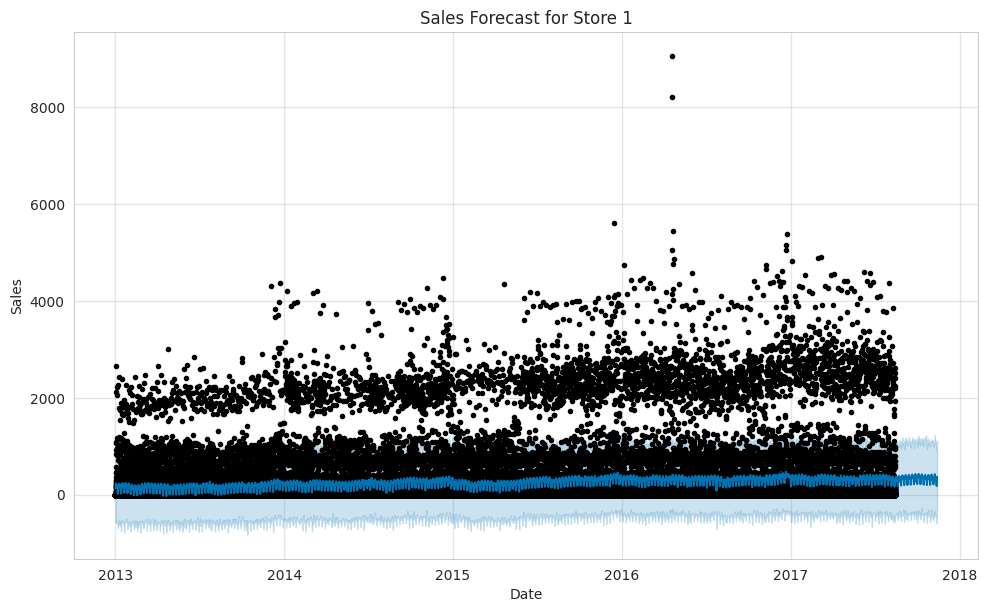

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:226: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:349: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:352: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

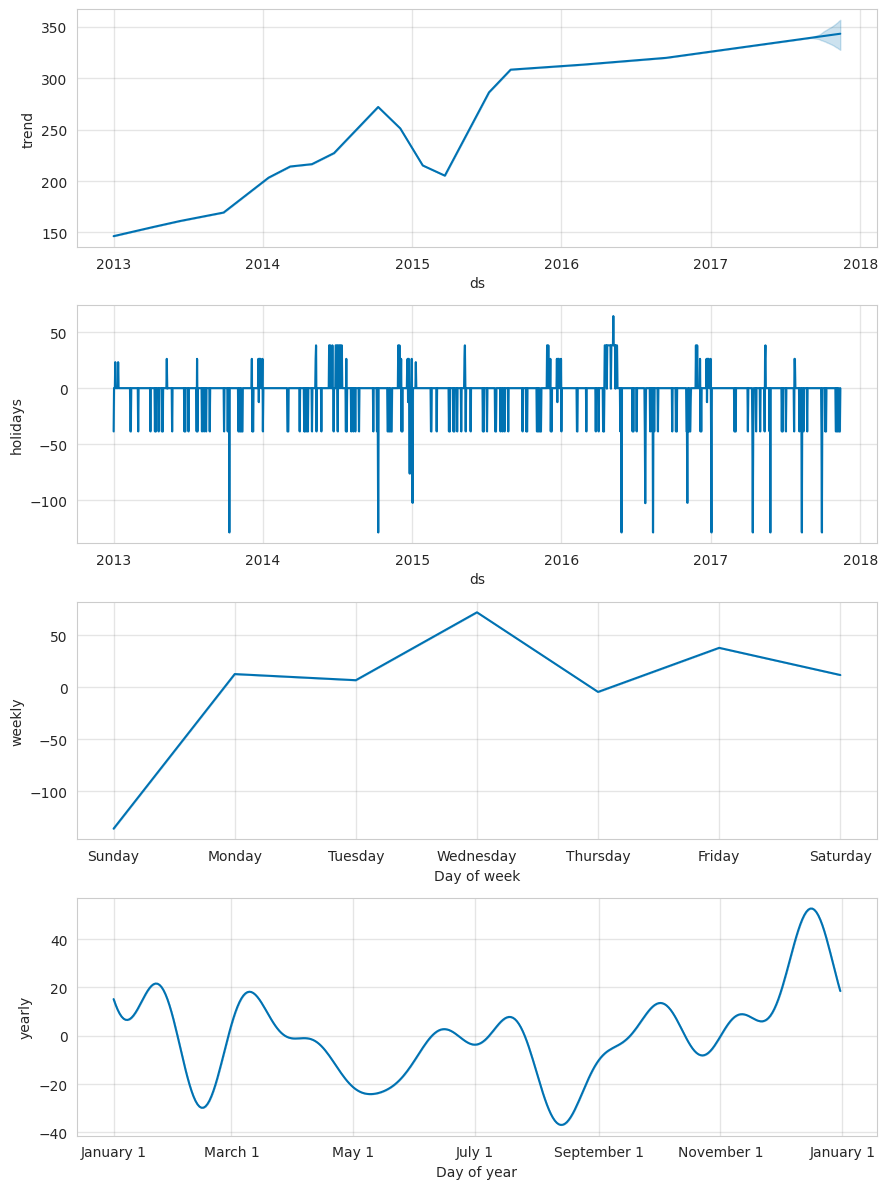

Submission file created successfully!


In [2]:
# Install fbprophet
!pip install prophet

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

# Set up the display environment
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load the datasets
holidays_events = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
sample_submission = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

# Display the first few rows of each dataset
print("Holidays Events:")
print(holidays_events.head())

print("\nOil:")
print(oil.head())

print("\nSample Submission:")
print(sample_submission.head())

print("\nStores:")
print(stores.head())

print("\nTest:")
print(test.head())

print("\nTrain:")
print(train.head())

print("\nTransactions:")
print(transactions.head())

# Basic Exploratory Data Analysis (EDA)
# Plot the sales over time for the first store
store_sales = train[train['store_nbr'] == 1].groupby('date').agg({'sales': 'sum'}).reset_index()
store_sales['date'] = pd.to_datetime(store_sales['date'])

plt.figure(figsize=(12, 6))
plt.plot(store_sales['date'], store_sales['sales'])
plt.title('Sales Over Time for Store 1')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Preparing data for Prophet
# Select one store for simplicity (store_nbr 1)
store_sales = train[train['store_nbr'] == 1][['date', 'sales']]
store_sales = store_sales.rename(columns={'date': 'ds', 'sales': 'y'})
store_sales['ds'] = pd.to_datetime(store_sales['ds'])

# Initialize the Prophet model
model = Prophet()

# Add holiday effects
holidays = holidays_events[['date', 'type']]
holidays.columns = ['ds', 'holiday']
holidays['ds'] = pd.to_datetime(holidays['ds'])
model = Prophet(holidays=holidays)

# Fit the model
model.fit(store_sales)

# Make a future dataframe for forecasting
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Sales Forecast for Store 1')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Plot forecast components
fig2 = model.plot_components(forecast)
plt.show()

# Prepare submission file
test['date'] = pd.to_datetime(test['date'])
test_forecast = model.predict(test[['date']].rename(columns={'date': 'ds'}))
submission = test[['id']].copy()
submission['sales'] = test_forecast['yhat']
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")
